In [1]:
# !pip install -U jupyter ipywidgets

In [2]:
small_model_ids = [
    "meta-llama/Llama-3.2-1B-Instruct",
    "allenai/OLMo-2-0425-1B-Instruct",
    "Qwen/Qwen3-0.6B",
    "HuggingFaceTB/SmolLM2-135M-Instruct"
]
big_model_ids = [
    "meta-llama/Llama-3.1-8B-Instruct",
    "allenai/OLMo-2-1124-7B-Instruct",
    "Qwen/Qwen3-8B",
    "HuggingFaceTB/SmolLM2-1.7B-Instruct",
]

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorWithPadding, set_seed, get_scheduler
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm


set_seed(
    42, 
    # deterministic=True # this refuses to work:
    )
device = "mps"


### Model, Tokenizer, hyperparams prep

# model_id = "allenai/OLMo-2-0425-1B-Instruct"
model_id = small_model_ids[2]
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    dtype="bfloat16",
    device_map=device,
    )
max_length = 512
batch_size = 1
num_epochs = 1

In [4]:
### Dataset prep
# dataset_id = "Neelectric/OpenR1-Math-220k_extended_Llama3_4096toks"
dataset_id = "Neelectric/OpenR1-Math-220k_CN-K12_OLMo-2_4096toks"

dataset_raw = load_dataset(dataset_id)["train"]
dataset_subset = dataset_raw.select(range(0,25))

In [5]:
### Dataset tokenization
system_prompt_content = "You are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>\n...\n</think>\n<answer>\n...\n</answer>"
system_prompt = [{
    "content": system_prompt_content,
    "role": "system"
    }]

def tokenize_function(example):
    messages =  system_prompt + example["messages"]
    templated = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    tokenized = tokenizer(
        templated, 
        truncation=False, 
        padding=False,
        )
    labels = tokenized["input_ids"].copy()
    # we need to be careful to mask padding tokens!!!
    labels = [-100 if token_id == tokenizer.pad_token_id else token_id for token_id in labels]
    tokenized["labels"] = labels
    return tokenized


first_sample = dataset_subset[0]
tokenized = tokenize_function(first_sample)
tokenized_dataset = dataset_subset.map(tokenize_function, num_proc=16)
tokenized_dataset = tokenized_dataset.remove_columns(['problem', 'solution', 'answer', 'problem_type', 'question_type', 'source', 'uuid', 'is_reasoning_complete', 'generations', 'correctness_math_verify', 'correctness_llama', 'finish_reasons', 'correctness_count', 'messages'])
print(tokenized_dataset)

Map (num_proc=16):   0%|          | 0/25 [00:00<?, ? examples/s]

Dataset({
    features: ['tokenized', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 25
})


In [6]:
### Data Collator and Data Loader prep
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,)
train_dataloader = DataLoader(
    tokenized_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
for batch in train_dataloader:
    break
batch["input_ids"]

tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  15235,  21388,
            429,   5707,   1632,   5504,   1497,    291,    323,  11682,  14507,
             13,   1446,   1156,   1744,    911,    279,  32711,   1882,    438,
            458,   5306,   1615,  76728,    323,   1221,   3410,    279,   1196,
            448,    279,   4226,     13,  39533,    304,    279,   2701,   3561,
             25,    220, 151667,    198,   9338, 151668,    198,     27,   9217,
            397,   9338,    522,   9217,     29, 151645,    198, 151644,    872,
            198,  47866,    279,   1102,    315,  57960,   2359,   4080,     18,
             59,   1291,  10699,  15136,    220,     17,      3,    382,     32,
             25,    400,     12,     20,  66426,     33,     25,    400,     12,
             16,  66426,     34,     25,    400,     12,     21,  66426,     35,
             25,    400,     21,      3, 151645,    198, 151644,  77091,    198,
         151667,    198,  32

In [7]:
# tokenizer.decode(batch["input_ids"][0])

# Let's compute the Fisher Diagonal

In [8]:
batch["input_ids"].shape

torch.Size([1, 413])

In [9]:
print(len(train_dataloader))

25


# quick plotting code

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def calc_fim_means(model, fisher, step_num):
    # Define parameter types in order (matching your plot)
    param_types = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']

    # Adjust based on your model
    num_layers = len(model.model.layers)

    # Create matrix to store mean FIM values
    fim_matrix = np.zeros((num_layers, len(param_types)))

    # Populate the matrix
    for name, fim_values in fisher.items():
        for i, ptype in enumerate(param_types):
            if ptype in name:
                # Extract layer number (assumes naming like model.layers.X....)
                parts = name.split('.')
                for j, part in enumerate(parts):
                    if part == 'layers' and j + 1 < len(parts):
                        layer_num = int(parts[j + 1])
                        # Option 1: mean FIM (normalized by param count)
                        fim_matrix[layer_num, i] = fim_values.mean().item() / step_num
                        break
                break

    # Create DataFrame
    df = pd.DataFrame(fim_matrix, 
                    index=[f'Layer {i}' for i in range(num_layers)],
                    columns=param_types)

    # Reverse so Layer 31 is at top
    df = df.iloc[::-1]
    return df

def plot_fim(df, batch_id, vmax, vmin):
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, cmap='viridis', cbar_kws={'label': 'Mean FIM'}, vmax=vmax, vmin=vmin)
    plt.xlabel('Parameters')
    plt.ylabel('Layers')
    plt.title(f'Mean Fisher Information per matrix:\n{model_id} at step {batch_id}')
    plt.tight_layout()
    save_path = f'plots/fim_heatmap/{model_id}/'
    from pathlib import Path
    Path(save_path).mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path + str(batch_id) + ".png", dpi=150)
    return

In [11]:
num_training_steps = num_epochs * len(train_dataloader)
print(f"Training for {num_training_steps} steps")
device = model.device
progress_bar = tqdm(range(num_training_steps))

from copy import deepcopy
import torch
fisher = {}
params = {name: param for name, param in model.named_parameters() if param.requires_grad}
for name, param in deepcopy(params).items():
    param.data.zero_()
    fisher[name] = param.data

### fisher estimation loop
model.eval()
all_dfs = []
step_num = 1
for epoch in range(num_epochs):
    for batch in train_dataloader:
        model.zero_grad()  # Looking at the formula for FIM it seems important that gradients do not accumulate 
        
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        # print(outputs)
        progress_bar.update(1)
        tqdm.write(f"loss is {loss.item()}")
        for name, param in model.named_parameters():
            if param.grad is not None:  
                fisher[name].data += param.grad.data ** 2 
        df = calc_fim_means(model, fisher, step_num)
        all_dfs.append(df)
        step_num += 1
        del outputs, loss  # might help with graph memory? not entirely sure
    break

Training for 25 steps


  0%|          | 0/25 [00:00<?, ?it/s]

loss is 0.9518863558769226
loss is 0.7154914140701294
loss is 0.9444370865821838
loss is 0.7429459691047668
loss is 0.8502296209335327
loss is 0.4758012890815735
loss is 0.6621965169906616
loss is 0.546474814414978
loss is 0.8417567610740662
loss is 0.7097994089126587
loss is 0.6117907166481018
loss is 1.1982417106628418
loss is 0.9137201309204102
loss is 0.6030824780464172
loss is 0.6235846877098083
loss is 0.7171783447265625
loss is 0.5750696063041687
loss is 0.8102853894233704
loss is 1.6862856149673462
loss is 0.9426127076148987
loss is 0.6771392822265625
loss is 0.5702592730522156
loss is 0.6587088108062744
loss is 0.5624126195907593
loss is 1.1277552843093872


/var/folders/cd/mlf9sxq5149cg7w9wbsbfd800000gp/T/ipykernel_36648/204219930.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


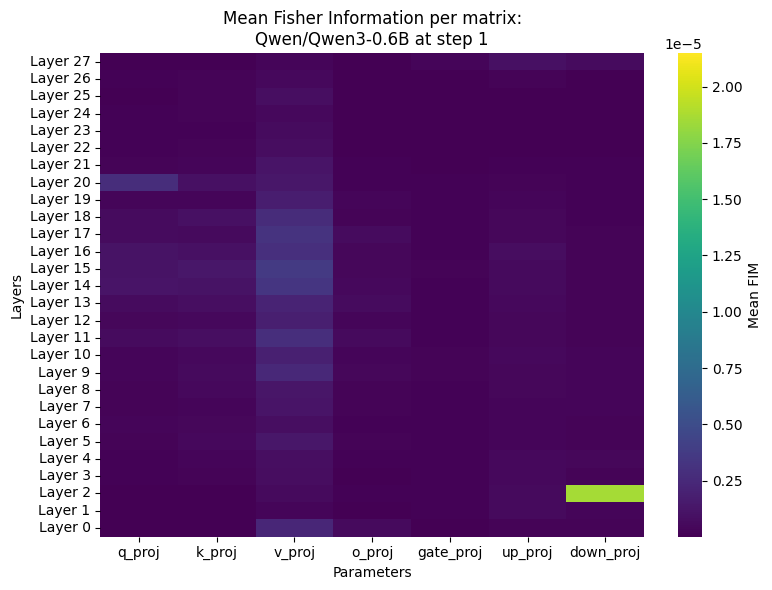

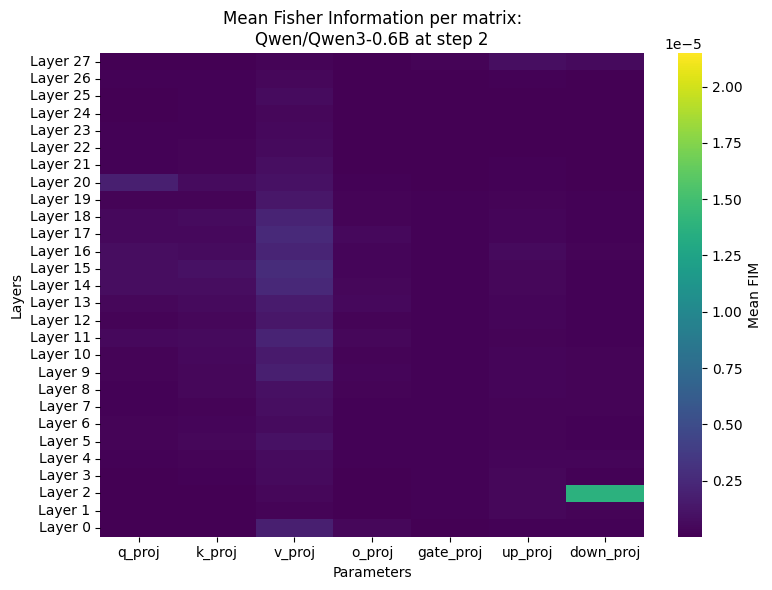

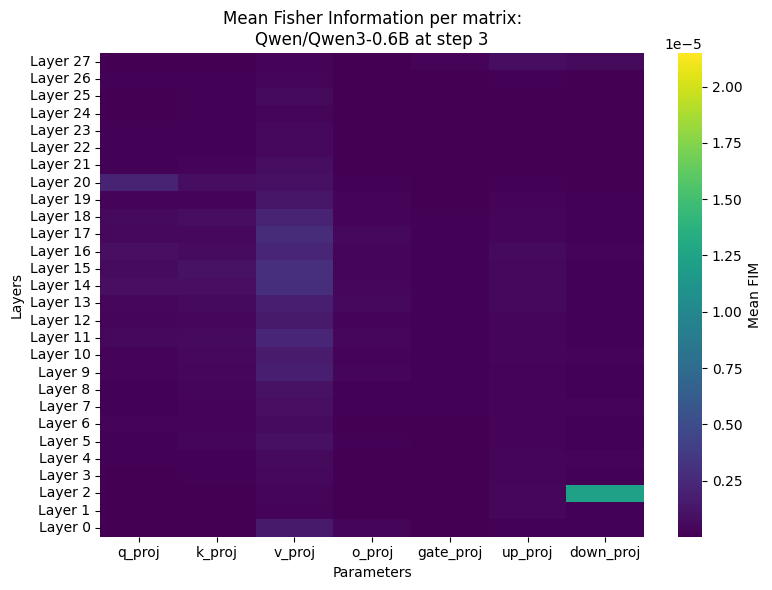

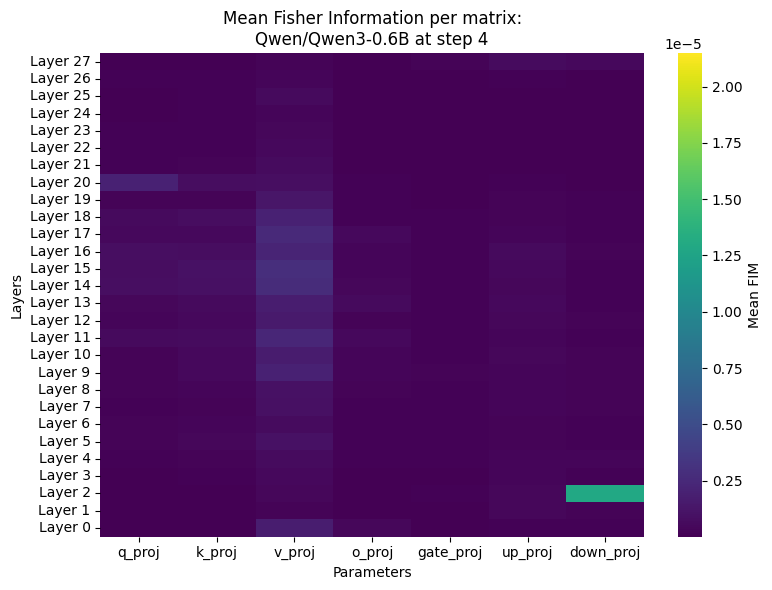

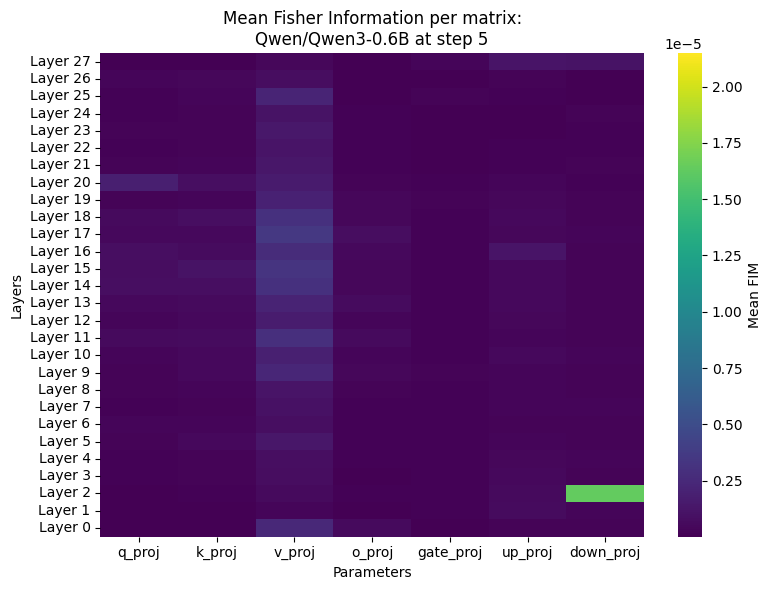

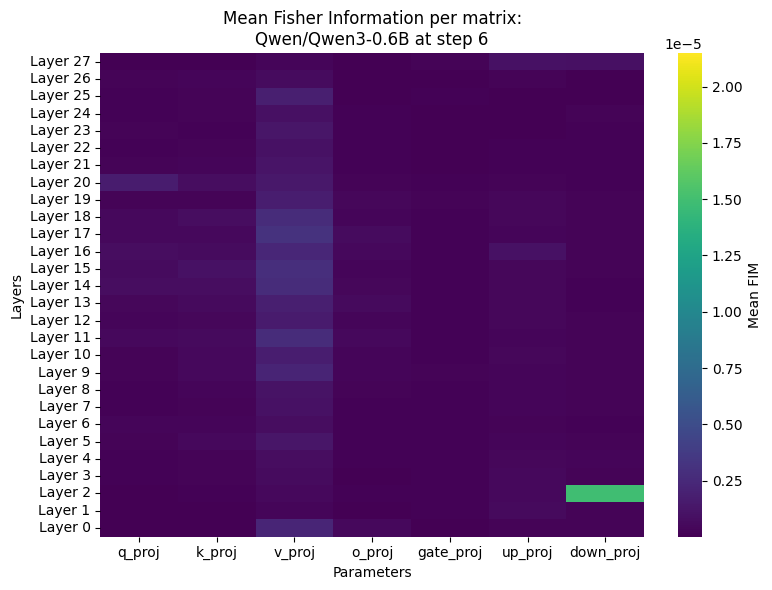

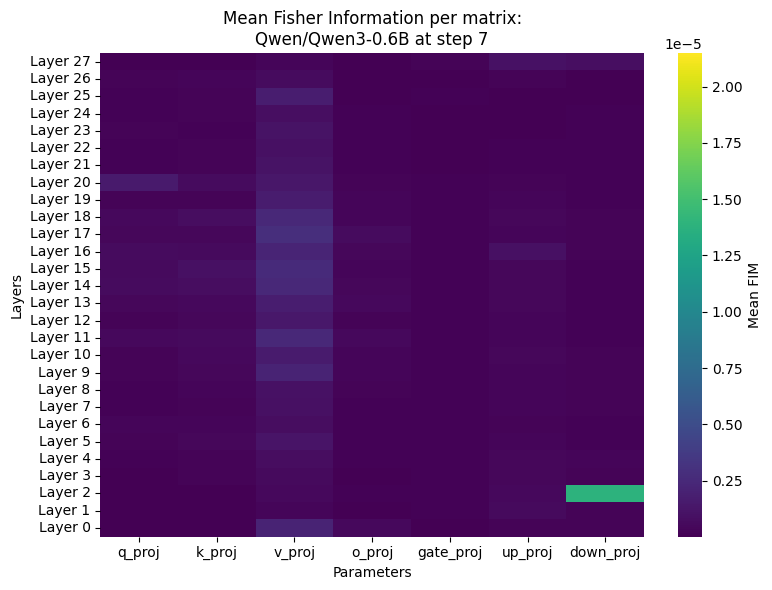

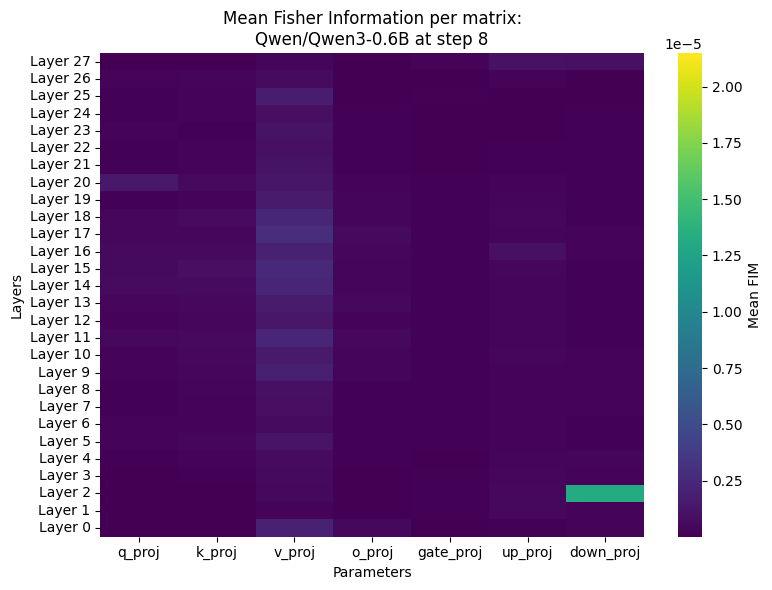

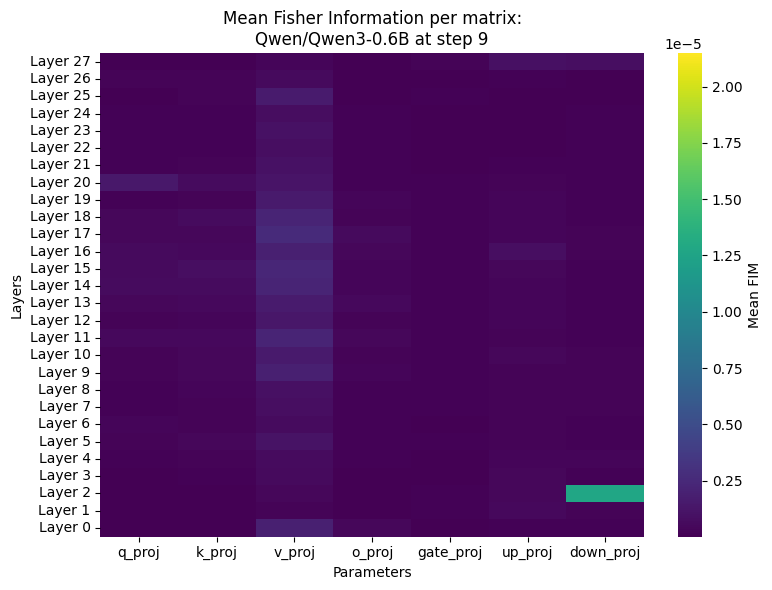

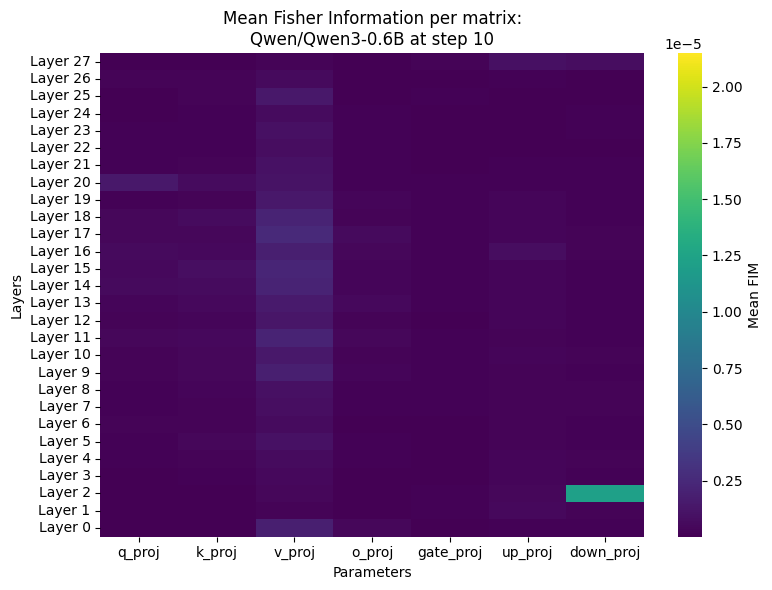

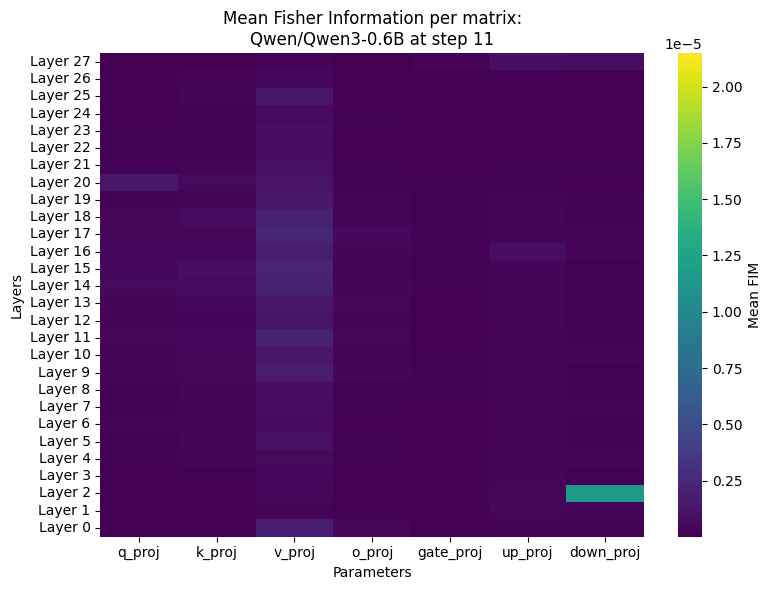

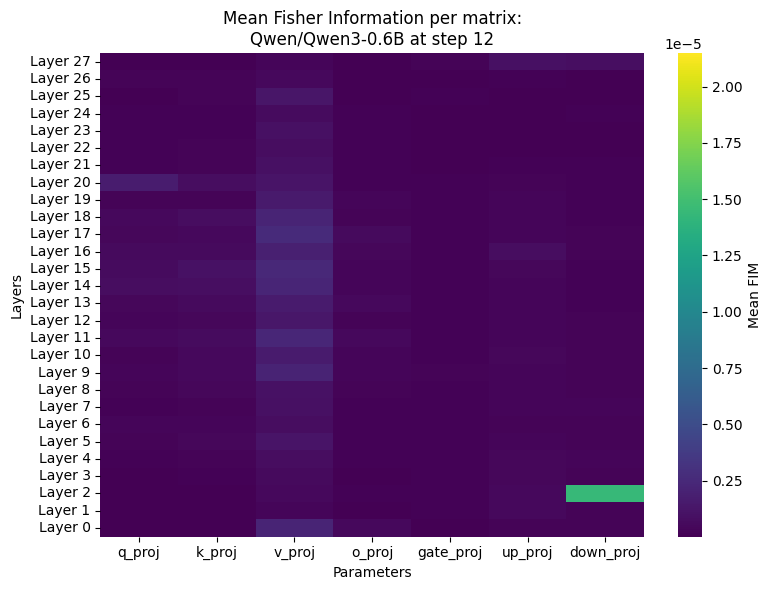

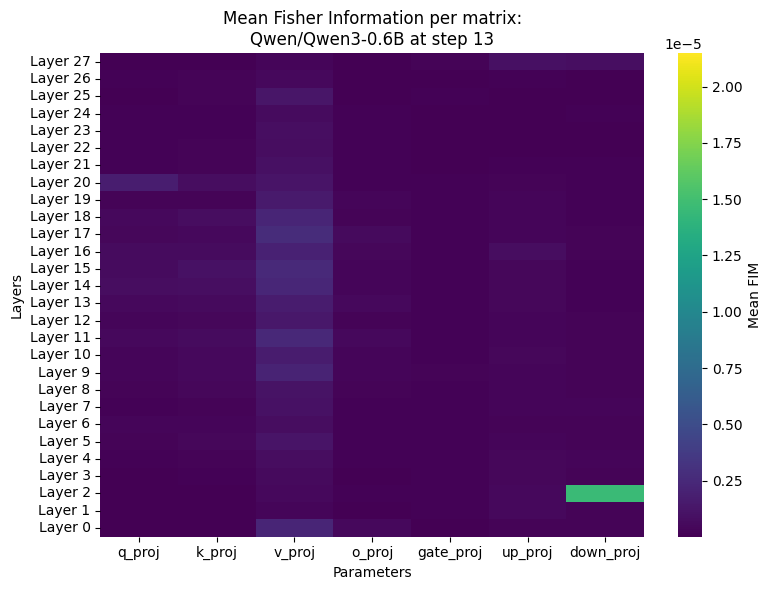

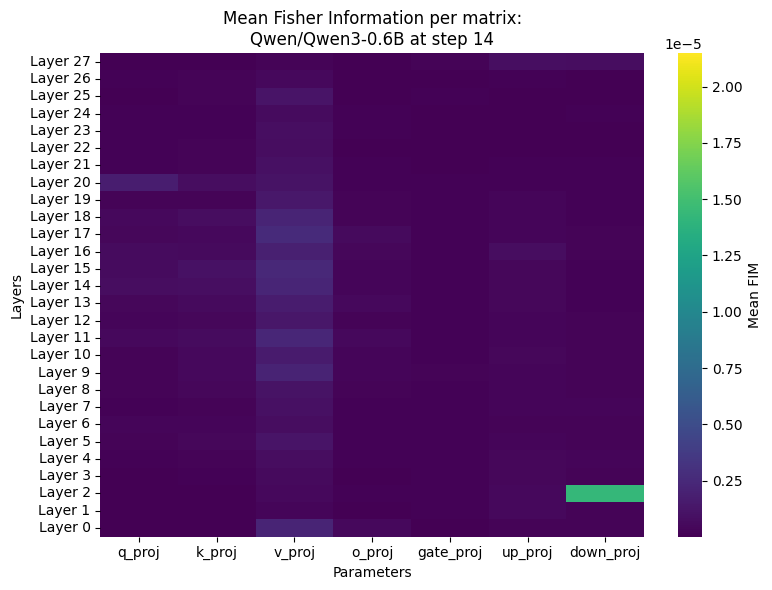

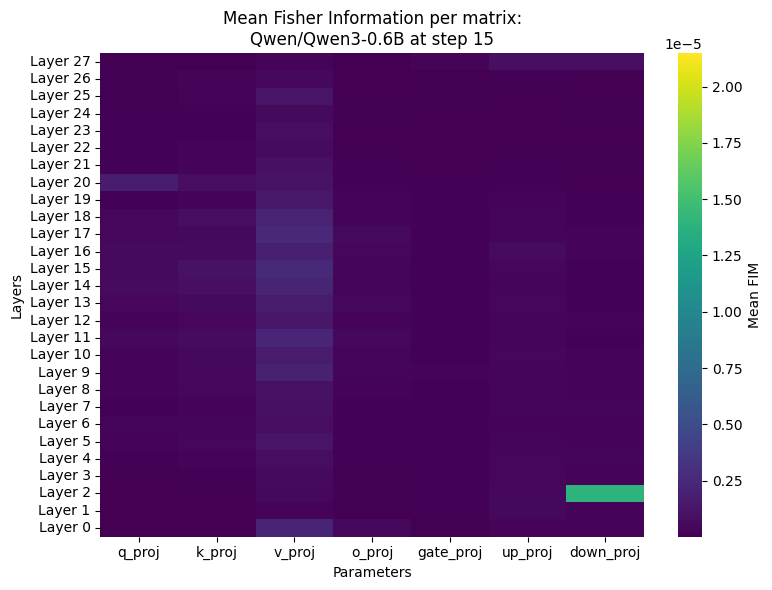

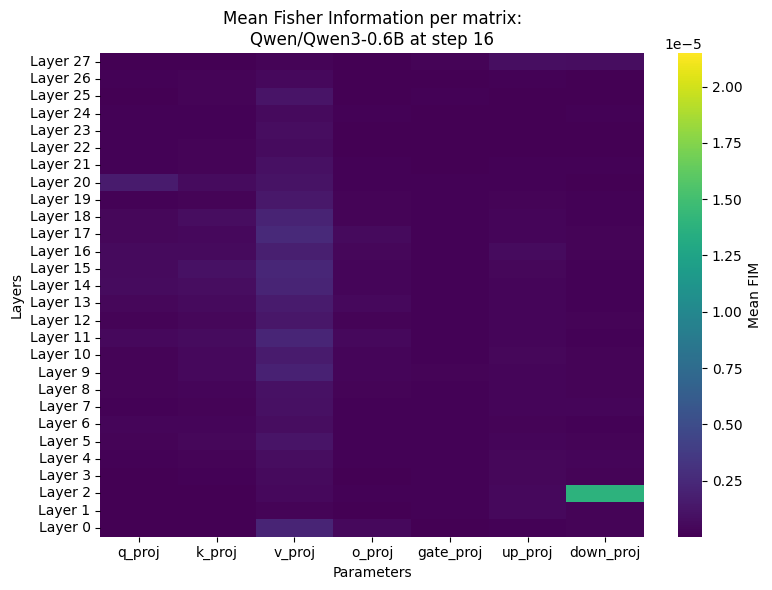

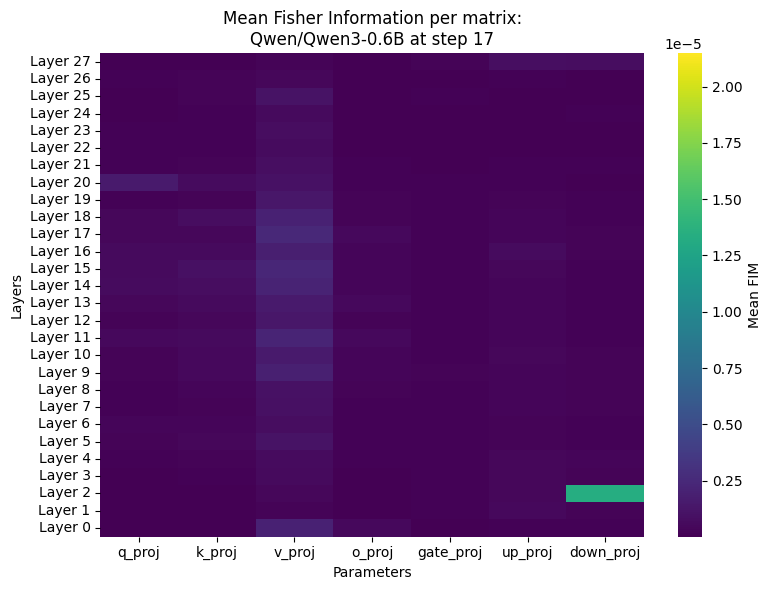

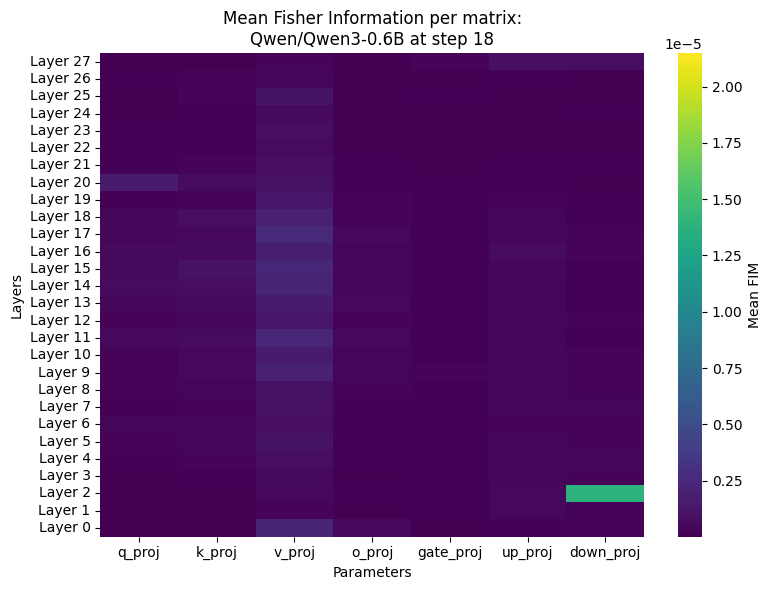

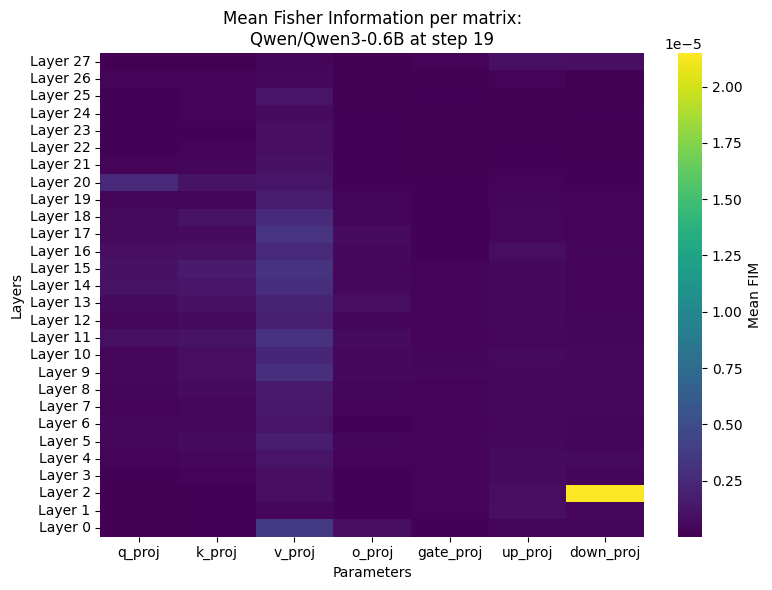

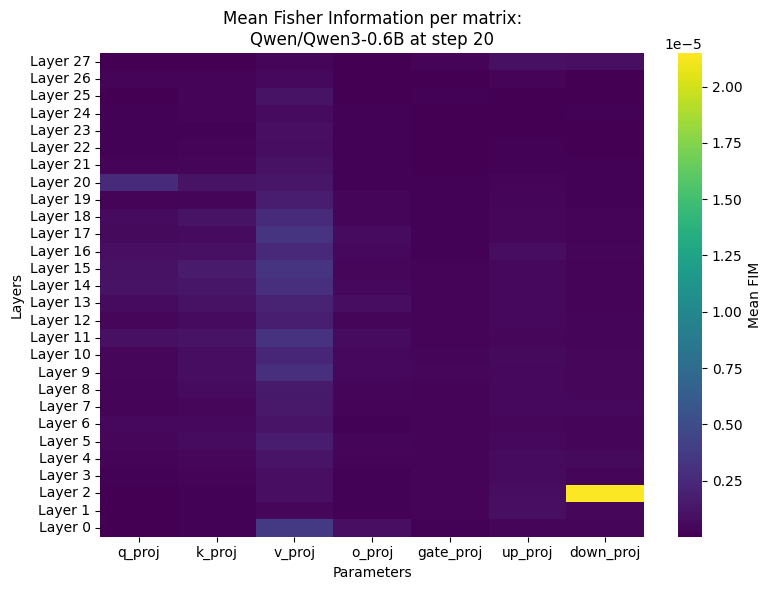

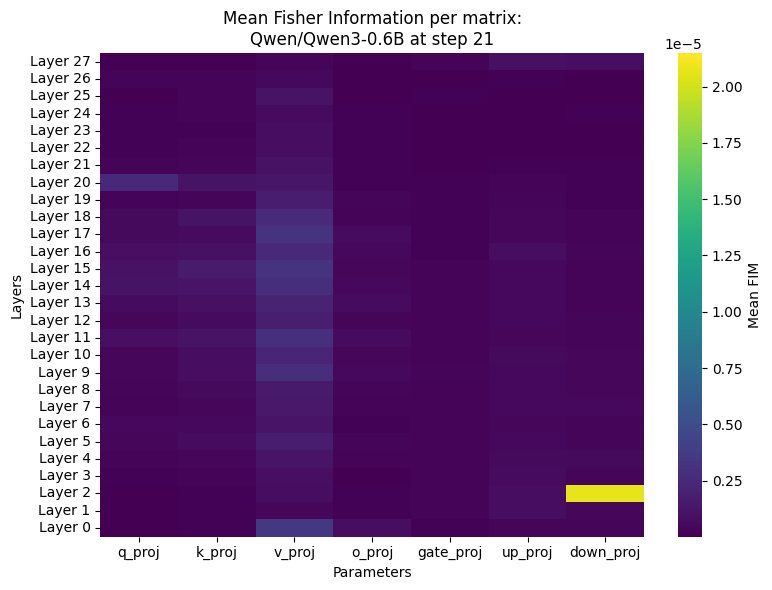

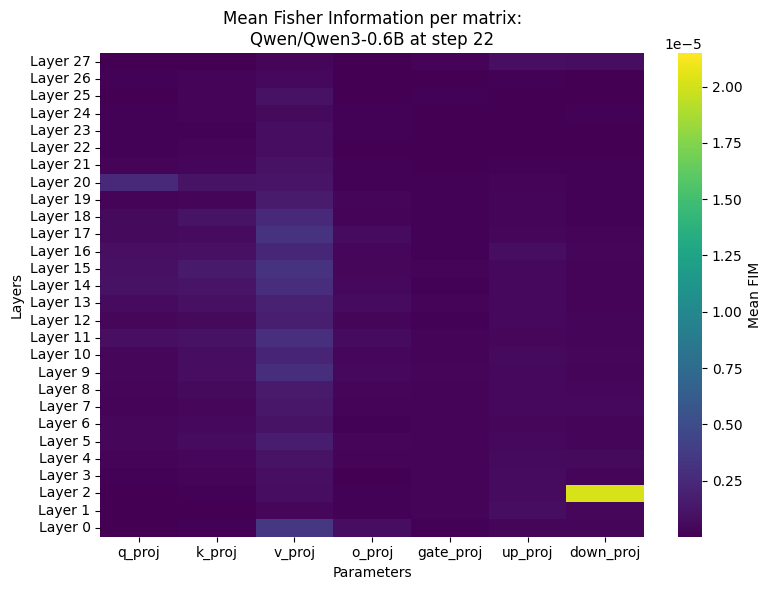

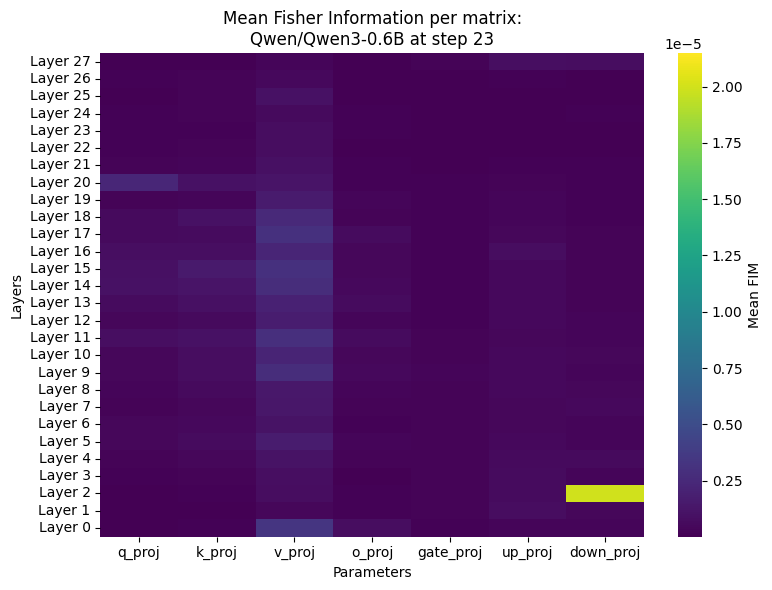

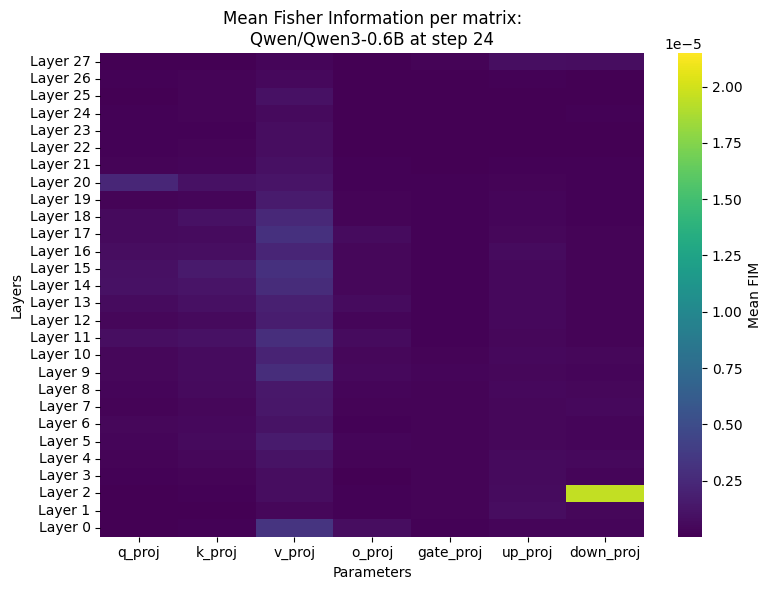

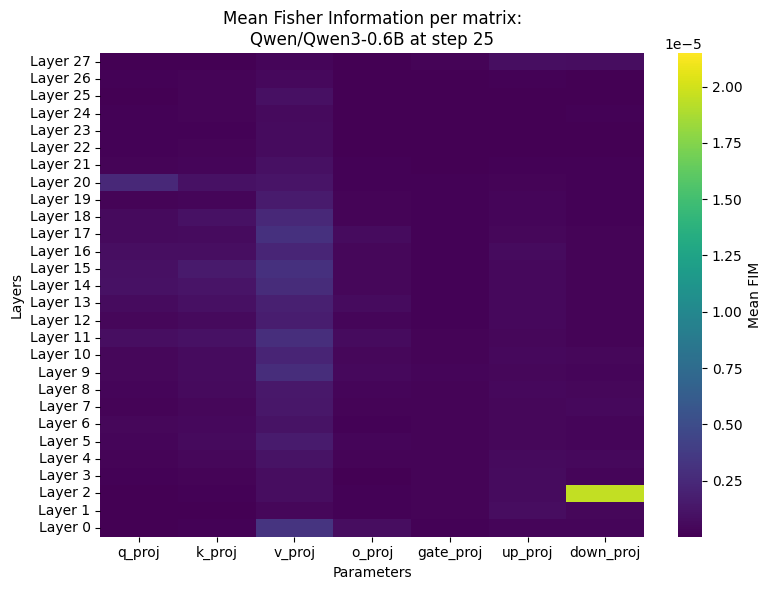

In [12]:
global_vmax = np.stack(all_dfs).max()
global_vmin = np.stack(all_dfs).min()
for i in range(len(all_dfs)):
    plot_fim(all_dfs[i], i+1, global_vmax, global_vmin)

In [13]:
from PIL import Image
from pathlib import Path

# Get the save path
save_path = f'plots/fim_heatmap/{model_id}/'

# Find all PNG files and sort by batch_id
png_files = sorted(Path(save_path).glob('*.png'), key=lambda x: int(x.stem))

# Load images
images = [Image.open(f) for f in png_files]

# Create GIF
model_name = model_id.split('/')[1]
output_path = f'fim_animation_{model_name}.gif'
images[0].save(
    output_path,
    save_all=True,
    duration=250,  # 300ms per frame
    loop=1,  # Loop forever
    append_images=images[1:] 
)

print(f"GIF saved to {output_path}")


GIF saved to fim_animation_Qwen3-0.6B.gif


In [14]:
params['model.embed_tokens.weight'][0]

tensor([-0.0093,  0.0337, -0.0747,  ...,  0.0120, -0.0106,  0.0160],
       device='mps:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

In [15]:
fisher['model.embed_tokens.weight'][0]

tensor([1.5736e-05, 2.7895e-05, 5.1036e-07,  ..., 6.2287e-06, 1.8358e-05,
        1.3709e-05], device='mps:0', dtype=torch.bfloat16)

# let's try and plot this?

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_fim(model, fim_matrix, batch_id):

    # Define parameter types in order (matching your plot)
    param_types = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']

    # Adjust based on your model
    num_layers = len(model.model.layers)

    # Create matrix to store mean FIM values
    fim_matrix = np.zeros((num_layers, len(param_types)))

    # Populate the matrix
    for name, fim_values in fisher.items():
        for i, ptype in enumerate(param_types):
            if ptype in name:
                # Extract layer number (assumes naming like model.layers.X....)
                parts = name.split('.')
                for j, part in enumerate(parts):
                    if part == 'layers' and j + 1 < len(parts):
                        layer_num = int(parts[j + 1])
                        # Option 1: mean FIM (normalized by param count)
                        fim_matrix[layer_num, i] = fim_values.mean().item()
                        break
                break

    # Create DataFrame
    df = pd.DataFrame(fim_matrix, 
                    index=[f'Layer {i}' for i in range(num_layers)],
                    columns=param_types)

    # Reverse so Layer 31 is at top
    df = df.iloc[::-1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, cmap='viridis', cbar_kws={'label': 'Mean FIM'})
    plt.xlabel('Parameters')
    plt.ylabel('Layers')
    plt.title(f'Mean Fisher Information per matrix:\n{model_id}')
    plt.tight_layout()
    save_path = f'plots/fim_heatmap/{model_id}/'
    from pathlib import Path
    Path(save_path).mkdir(parents=True, exist_ok=True)

    plt.savefig(save_path + str(batch_id) + ".png", dpi=150)